In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.autograd as autograd
import torch.cuda.comm as comm
from torch.autograd.function import once_differentiable
import time
import functools
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from torchvision import transforms

def getData(mode):
    if mode== 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values),np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values),np.squeeze(label.values)
    
class RetinopathyLoaDER(data.Dataset):
    def __init__(self, root,mode):
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        self.train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(), transforms.RandomRotation(45), transforms.ToTensor()])
        
        self.test_transform = transforms.ToTensor()
        print(">Found %d images..." %(len(self.img_name)))
    
    def __len__(self):
        return len(self.img_name)
    
    def __getitem__(self,index):
        path = self.root +'/' +self.img_name[index]+'.jpeg'
        img_Im = Image.open(path)
        if self.mode == "train":
            img = self.train_transform(img_Im)
        else:
            img = self.test_transform(img_Im)
        label = self.label[index]
        return img, label
    

In [ ]:
class ResNet(nn.Module):
    def __init__(self, Layer=18,Pretrained=True):
        super(ResNet, self).__init__()
        if Layer==18:
            self.classify = nn.Linear(512, 5)
        if Layer==50:
            self.classify = nn.Linear(2048, 5)
        
        pretrained_model = torchvision.models.__dict__['resnet{}'.format(Layer)](pretrained=Pretrained)
        self.conv1 = pretrained_model._modules['conv1']
        self.bn1 = pretrained_model._modules['bn1']
        self.relu = pretrained_model._modules['relu']
        self.maxpool = pretrained_model._modules['maxpool']

        self.layer1 = pretrained_model._modules['layer1']
        self.layer2 = pretrained_model._modules['layer2']
        self.layer3 = pretrained_model._modules['layer3']
        self.layer4 = pretrained_model._modules['layer4']

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        del pretrained_model

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # print(x.shape)
        x = torch.flatten(x,start_dim=1)
        
        x = self.classify(x)

        return x

In [ ]:
def draw_acc_graph(acc_list, name_list, color, title, epoch_num):
    epoch = range(epoch_num)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    for acc_list_idx , name_list_idx ,color_idx in zip(acc_list, name_list, color):
        plt.plot(epoch, acc_list_idx, color_idx, label=name_list_idx)
    plt.legend()
    plt.show()
    
def draw_confusion_matrix(network,pretrained,ground_truth, prediction):
    title = "Resnet"+str(network)+" pretrained "+str(pretrained)+" confusion matrix"
    cm = confusion_matrix(ground_truth, prediction, labels=[0,1,2,3,4],normalize='true')
    print(title)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
    disp.plot()
    plt.show()
    
def print_highest_acc(acc_list, name_list):
    print("highest_acc:")
    for acc_list_idx , name_list_idx in zip(acc_list, name_list):
        print(name_list_idx,": ",max(acc_list_idx),"%")

In [ ]:
#Train
def set_paremeter_requires_grads(layer,is_required):
    if is_required:
        for param in layer.parameters():
            param.requires_grad = True
    else:
        for param in layer.parameters():
            param.requires_grad = False
def append_model_grad(model_grad,model):
    for param in model.parameters():
        if param.requires_grad == True:
            model_grad.append(param)
            
def train(model,train_loader,Momentum,wd,lr,epoch_i,pretrained,device):
    if pretrained:
        ct = 0
        model_grad=[]
        
        for children in model.children():
            ct += 1
            if (ct > 1) & (epoch_i<3):
                set_paremeter_requires_grads(children,0)
            else:
                set_paremeter_requires_grads(children,1)   
                
        append_model_grad(model_grad,model)
        optimizer = optim.SGD(model_grad,momentum=Momentum,lr = lr,weight_decay = wd)
    
    else:
        optimizer = optim.SGD(model.parameters(),momentum=Momentum,lr = lr,weight_decay = wd)
    
    model.train()
    total_num = len(train_loader.dataset)
    true_num = 0
    loss_fn = torch.nn.CrossEntropyLoss()   
    for batch_idx, (data, label) in enumerate(train_loader):
        #training
        data, label =data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output,label)
        loss.backward()
        optimizer.step()
        #calculate true output
        prediction = torch.argmax(output,dim=1)
        true_num += torch.count_nonzero(torch.where(label==prediction, 1, 0)).item()
    #return acc
    return 100*true_num/total_num

#Test
def test(model,test_loader,device):
    model.eval()
    total_num = len(test_loader.dataset)
    true_num = 0
    prediction_all=[]
    with torch.no_grad():
        for data, label in test_loader:
            data, label =data.to(device), label.to(device)            
            output = model(data)
            prediction = torch.argmax(output,dim=1)
            prediction_all.extend(prediction.tolist())
            true_num += torch.count_nonzero(torch.where(label==prediction, 1, 0)).item()
    return prediction_all,100*true_num/total_num

In [ ]:
def model_init_train_and_test(device,train_loader,test_loader,lr = 1e-3,epoch = 1,network=18,pretrained=True,batch_size= 4):
    Momentum = 0.9
    wd = 5e-4
    model = ResNet(network,pretrained).to(device) 
    
    train_acc_list = []
    test_acc_list = []
    best_prediction =[]
    highest_test_acc=0
    for epoch_i in range(epoch):
        train_acc = train(model,train_loader,Momentum,wd,lr,epoch_i,pretrained,device)
        prediction_outcome, test_acc = test(model,test_loader,device)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("epoch: ",epoch_i+1," train acc: ",train_acc," test acc: ",test_acc)
        
        if test_acc>highest_test_acc:
            highest_test_acc = test_acc
            best_prediction = prediction_outcome
            if os.path.exists("Resnet"+str(network)+"_pretrained="+str(pretrained)+"_model"):
                os.remove("Resnet"+str(network)+"_pretrained="+str(pretrained)+"_model")
            torch.save(model.state_dict(), "Resnet"+str(network)+"_pretrained="+str(pretrained)+"_model")
    return best_prediction, train_acc_list, test_acc_list

In [ ]:
def model_main(batch_size):
    #hyperparameter
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    network_list=[18,50]
    pretrained_list=[True,False]
    train_custumized_dataset = RetinopathyLoaDER("data","train")
    test_custumized_dataset = RetinopathyLoaDER("data","test")
    #Load Data
    train_loader = DataLoader(train_custumized_dataset,batch_size=batch_size)
    test_loader = DataLoader(test_custumized_dataset,batch_size=batch_size)
    
    print("acc:")
    for network in network_list:
        for pretrained in pretrained_list:
            model = ResNet(network,pretrained).to(device)
            model.load_state_dict(torch.load("Resnet"+str(network)+"_pretrained="+str(pretrained)+"_model"))
            model.eval()
            prediction , test_acc = test(model,test_loader,device)
            print("Resnet"+str(network)+"_pretrained="+str(pretrained)+"_model: ",test_acc,"%")
            draw_confusion_matrix(network,pretrained,test_loader.dataset.label.tolist(),prediction)

In [ ]:
def no_model_main(model_name_list,batch_size= 4):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    lr = 1e-3        
    epoch = 15
    network_list=[18,50]
    pretrained_list=[True,False]
    draw_color_list=['b','g','r','c']
    train_custumized_dataset = RetinopathyLoaDER("data","train")
    test_custumized_dataset = RetinopathyLoaDER("data","test")
    train_loader = DataLoader(train_custumized_dataset,batch_size=batch_size)
    test_loader = DataLoader(test_custumized_dataset,batch_size=batch_size)
    
    highest_acc_list=[]
    highest_name_list=[]
    count=0
    for network in network_list:
        draw_acc_list=[]
        draw_name_list=[]
        draw_title="Activation function comparision(Resnet"+str(network)+")"
        for pretrained in pretrained_list:
            model_name=model_name_list[count]
            count += 1
            if os.path.exists(model_name) == 0:
                best_prediction, train_acc_list, test_acc_list = model_init_train_and_test(device,train_loader,test_loader,lr = lr,epoch = epoch,network=network,pretrained=pretrained,batch_size= batch_size)
                draw_acc_list.append(train_acc_list)
                draw_acc_list.append(test_acc_list)
                draw_name_list.append("resnet"+str(network)+"_pretrained="+str(pretrained)+"_train")
                draw_name_list.append("resnet"+str(network)+"_pretrained="+str(pretrained)+"_test")
                highest_acc_list.append(test_acc_list)
                highest_name_list.append("resnet"+str(network)+"_pretrained="+str(pretrained)+"_test")
                draw_confusion_matrix(network,pretrained,test_loader.dataset.label.tolist(),best_prediction)
            else:
                model = ResNet(network,pretrained).to(device)
                model.load_state_dict(torch.load("Resnet"+str(network)+"_pretrained="+str(pretrained)+"_model"))
                model.eval()
                prediction , test_acc = test(model,test_loader,device)
                print("Resnet"+str(network)+"_pretrained="+str(pretrained)+"_model: ",test_acc,"%")
                draw_confusion_matrix(network,pretrained,test_loader.dataset.label.tolist(),prediction)
        draw_acc_graph(draw_acc_list, draw_name_list, draw_color_list, draw_title, epoch)
        
    print_highest_acc(highest_acc_list, highest_name_list)

>Found 28099 images...
>Found 7025 images...
epoch:  1  train acc:  73.41186519093206  test acc:  73.63701067615658
epoch:  2  train acc:  73.6574255311577  test acc:  73.90747330960853
epoch:  3  train acc:  73.86739741627817  test acc:  74.02135231316726
epoch:  4  train acc:  76.3977365742553  test acc:  77.59430604982207
epoch:  5  train acc:  78.89960496814834  test acc:  78.44839857651246
epoch:  6  train acc:  80.0669062955977  test acc:  77.83629893238434
epoch:  7  train acc:  80.6719100323855  test acc:  79.7153024911032
epoch:  8  train acc:  81.13811879426314  test acc:  80.25622775800711
epoch:  9  train acc:  81.38367913448877  test acc:  80.55516014234875
epoch:  10  train acc:  81.83565251432435  test acc:  80.66903914590748
epoch:  11  train acc:  82.01359478985017  test acc:  81.38078291814946
epoch:  12  train acc:  82.40506779600697  test acc:  81.12455516014235
epoch:  13  train acc:  82.40150895049646  test acc:  81.11032028469751
epoch:  14  train acc:  82.935335

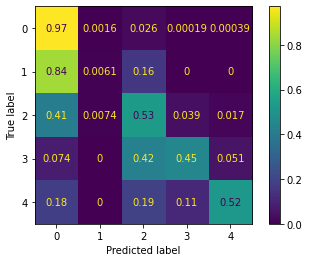

epoch:  1  train acc:  73.34068828072174  test acc:  73.35231316725978
epoch:  2  train acc:  73.4866009466529  test acc:  73.25266903914591
epoch:  3  train acc:  73.47236556461084  test acc:  73.30960854092527
epoch:  4  train acc:  73.49015979216342  test acc:  73.33807829181495
epoch:  5  train acc:  73.49371863767394  test acc:  73.30960854092527
epoch:  6  train acc:  73.45457133705825  test acc:  73.32384341637011
epoch:  7  train acc:  73.4652478735898  test acc:  73.29537366548043
epoch:  8  train acc:  73.46168902807929  test acc:  73.29537366548043
epoch:  9  train acc:  73.49371863767394  test acc:  73.32384341637011
epoch:  10  train acc:  73.49015979216342  test acc:  73.35231316725978
epoch:  11  train acc:  73.49015979216342  test acc:  73.33807829181495
epoch:  12  train acc:  73.49727748318446  test acc:  73.35231316725978
epoch:  13  train acc:  73.50083632869497  test acc:  73.36654804270462
epoch:  14  train acc:  73.51151286522652  test acc:  73.30960854092527
epo

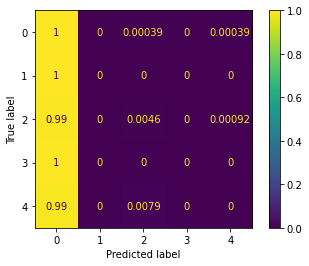

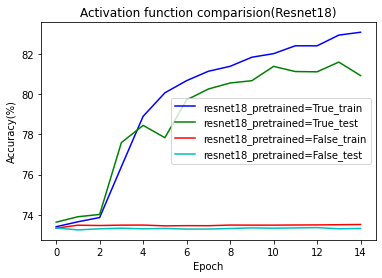

epoch:  1  train acc:  73.44745364603723  test acc:  73.36654804270462
epoch:  2  train acc:  73.53998362931065  test acc:  73.87900355871886
epoch:  3  train acc:  73.81757357913094  test acc:  74.22064056939502
epoch:  4  train acc:  77.51165521904694  test acc:  79.30249110320284
epoch:  5  train acc:  79.75372789067227  test acc:  80.62633451957295
epoch:  6  train acc:  81.01711804690558  test acc:  81.05338078291815
epoch:  7  train acc:  81.68973984839319  test acc:  80.74021352313167
epoch:  8  train acc:  82.38727356845439  test acc:  81.79359430604983
epoch:  9  train acc:  82.73959927399551  test acc:  82.14946619217082
epoch:  10  train acc:  83.2378376454678  test acc:  81.30960854092527
epoch:  11  train acc:  83.65066372468772  test acc:  81.29537366548043
epoch:  12  train acc:  83.9745186661447  test acc:  81.77935943060498
epoch:  13  train acc:  84.26990284351756  test acc:  81.5373665480427
epoch:  14  train acc:  84.8001708245845  test acc:  79.7153024911032
epoch:

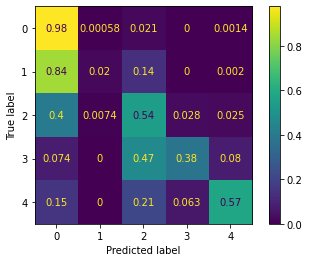

epoch:  1  train acc:  72.87803836435461  test acc:  73.35231316725978
epoch:  2  train acc:  73.25171714295882  test acc:  73.30960854092527
epoch:  3  train acc:  73.31577636214811  test acc:  73.25266903914591
epoch:  4  train acc:  73.32645289867966  test acc:  73.29537366548043
epoch:  5  train acc:  73.3549236627638  test acc:  73.30960854092527
epoch:  6  train acc:  73.38695327235844  test acc:  73.20996441281139
epoch:  7  train acc:  73.41186519093206  test acc:  73.15302491103203
epoch:  8  train acc:  73.37983558133742  test acc:  73.09608540925267
epoch:  9  train acc:  73.41542403644257  test acc:  73.16725978647686
epoch:  10  train acc:  73.39051211786897  test acc:  73.067615658363
epoch:  11  train acc:  73.40830634542155  test acc:  73.02491103202847
epoch:  12  train acc:  73.39051211786897  test acc:  72.93950177935943
epoch:  13  train acc:  73.39407096337948  test acc:  72.8540925266904
epoch:  14  train acc:  73.39407096337948  test acc:  72.75444839857651
epoch

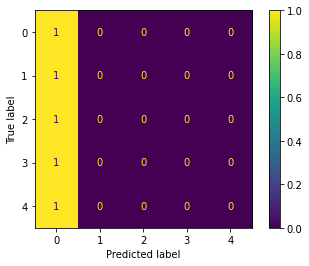

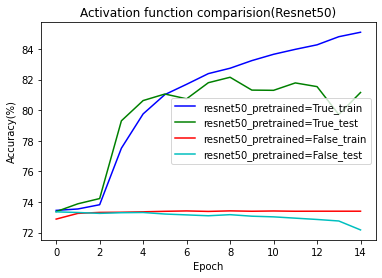

highest_acc:
resnet18_pretrained=True_test :  81.59430604982207 %
resnet18_pretrained=False_test :  73.36654804270462 %
resnet50_pretrained=True_test :  82.14946619217082 %
resnet50_pretrained=False_test :  73.35231316725978 %


In [ ]:
if __name__ == "__main__":
    models_is_exist = 1
    model_name_list = ["Resnet18_pretrained=True_model","Resnet18_pretrained=False_model","Resnet50_pretrained=True_model","Resnet50_pretrained=False_model"]
    for model_name in model_name_list:
        if os.path.exists(model_name) == 0:
            models_is_exist = 0
            break
            
    batch_size=32
    if models_is_exist:
        model_main(batch_size)
    else:
        no_model_main(model_name_list,batch_size)